# **Lab 7.2 CNN**

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.optim as optim

Complete the `load_data()` function that loads the image using `ImageFolder()` with the specific `transforms.compose()` provided below.
`load_data()` will return `DataLoader()` and print the information about the Dataset.
This function must load only a pair of classes from the entire dataset.
Please ensure that the final image is in grayscale and has a size of 28x28.

`transforms.Compose()` :
- `transforms.Resize()`
- `transforms.ToTensor()`
- `transforms.Pad()`
- `transforms.RandomRotation(),`
- `transforms.CenterCrop()`

Resource : [`transforms.Compose()`](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html#compose), [`torchvision.transforms v1`](<https://pytorch.org/vision/stable/transforms.html#v1-api-reference:~:text=custom)%20tv_tensor%20type.-,V1%20API%20Reference,-Geometry>)

In [53]:
def load_data(path,class_names=None):
    ### START CODE HERE ###
    transform = transforms.Compose([
        transforms.Grayscale(),  # Convert to grayscale
        transforms.Resize((32, 32)),  # Resize image to 28x28
        transforms.Pad(padding=32,padding_mode='reflect'),
        transforms.RandomRotation(15),  # Apply random rotation
        transforms.CenterCrop(32),  # Apply center crop
        transforms.ToTensor()
    ])

    # Load dataset with ImageFolder
    full_dataset = ImageFolder(root=path, transform=transform)
    # # print(full_dataset.classes)
    # # เอาเฉพาะประเภทที่เลือก [0,1]
    # class_to_idx = full_dataset.class_to_idx
    # selected_indices = [i for i, (img, label) in enumerate(full_dataset) if full_dataset.classes[label] in class_names]
    # # print(selected_indices)
    # # จัดให้ข้อมูลทั้งหมด มีแค่ 0,1 (ประเภทที่เลือก)
    # subset_dataset = Subset(full_dataset, selected_indices)

    # # Create DataLoader for training and testing (using 80/20 split)
    train_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    # # DataLoader
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    train_class_0 = sum(1 for _, label in train_loader.dataset if label == 0)
    train_class_1 = sum(1 for _, label in train_loader.dataset if label == 1)
    train_class_2 = sum(1 for _, label in train_loader.dataset if label == 2)
    train_class_3 = sum(1 for _, label in train_loader.dataset if label == 3)
    train_class_4 = sum(1 for _, label in train_loader.dataset if label == 4)
    train_class_5 = sum(1 for _, label in train_loader.dataset if label == 5)
    train_class_6 = sum(1 for _, label in train_loader.dataset if label == 6)
    train_class_7 = sum(1 for _, label in train_loader.dataset if label == 7)
    train_class_8 = sum(1 for _, label in train_loader.dataset if label == 8)
    train_class_9 = sum(1 for _, label in train_loader.dataset if label == 9)
    
    test_class_0 = sum(1 for _, label in test_loader.dataset if label == 0)
    test_class_1 = sum(1 for _, label in test_loader.dataset if label == 1)
    test_class_2 = sum(1 for _, label in test_loader.dataset if label == 2)
    test_class_3 = sum(1 for _, label in test_loader.dataset if label == 3)
    test_class_4 = sum(1 for _, label in test_loader.dataset if label == 4)
    test_class_5 = sum(1 for _, label in test_loader.dataset if label == 5)
    test_class_6 = sum(1 for _, label in test_loader.dataset if label == 6)
    test_class_7 = sum(1 for _, label in test_loader.dataset if label == 7)
    test_class_8 = sum(1 for _, label in test_loader.dataset if label == 8)
    test_class_9 = sum(1 for _, label in test_loader.dataset if label == 9)
    
    print("📃Train Dataset:")
    print("     Number of images in class 0:", train_class_0)
    print("     Number of images in class 1:", train_class_1)
    print("     Number of images in class 1:", train_class_2)
    print("     Number of images in class 1:", train_class_3)
    print("     Number of images in class 1:", train_class_4)
    print("     Number of images in class 1:", train_class_5)
    print("     Number of images in class 1:", train_class_6)
    print("     Number of images in class 1:", train_class_7)
    print("     Number of images in class 1:", train_class_8)
    print("     Number of images in class 1:", train_class_9)
    print("     Number of training samples:", len(train_loader.dataset))
    print("📃Test Dataset:")
    print("     Number of images in class 0:", test_class_0)
    print("     Number of images in class 1:", test_class_1)
    print("     Number of images in class 1:", test_class_2)
    print("     Number of images in class 1:", test_class_3)
    print("     Number of images in class 1:", test_class_4)
    print("     Number of images in class 1:", test_class_5)
    print("     Number of images in class 1:", test_class_6)
    print("     Number of images in class 1:", test_class_7)
    print("     Number of images in class 1:", test_class_8)
    print("     Number of images in class 1:", test_class_9)
    print("     Number of training samples:", len(test_loader.dataset))
    # ### END CODE HERE ###
    return train_loader, test_loader

Use your `load_data()` function to load the dataset in the cell below. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

```
📃Train Dataset:
	Number of images in class 0: 313
	Number of images in class 1: 308
	Number of training samples: 621

📃Test Dataset:
	Number of images in class 0: 75
	Number of images in class 1: 81
	Number of testing samples: 156
```


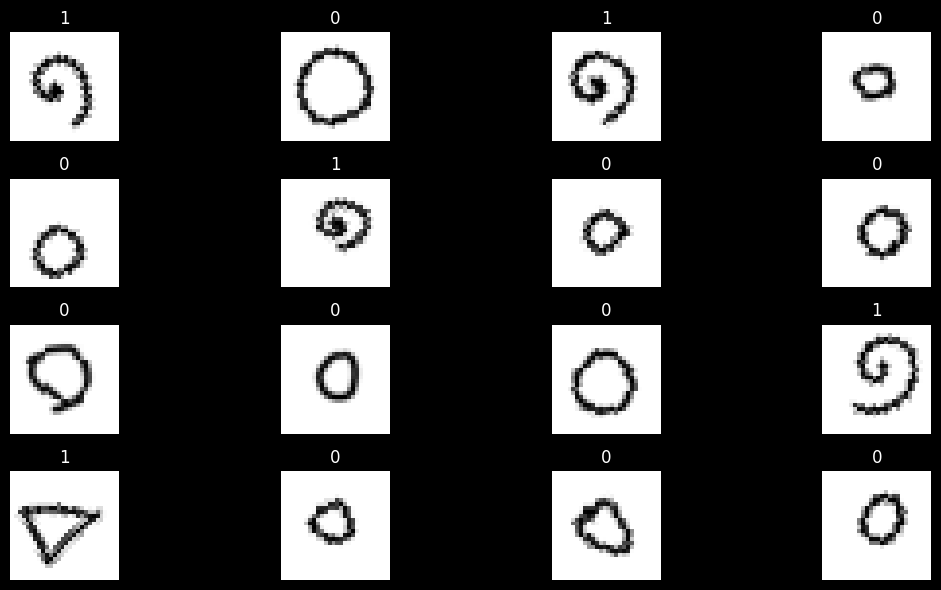

</details>

📃Train Dataset:
     Number of images in class 0: 272
     Number of images in class 1: 275
     Number of images in class 1: 264
     Number of images in class 1: 283
     Number of images in class 1: 283
     Number of images in class 1: 290
     Number of images in class 1: 261
     Number of images in class 1: 272
     Number of images in class 1: 273
     Number of images in class 1: 276
     Number of training samples: 2749
📃Test Dataset:
     Number of images in class 0: 69
     Number of images in class 1: 73
     Number of images in class 1: 86
     Number of images in class 1: 67
     Number of images in class 1: 59
     Number of images in class 1: 50
     Number of images in class 1: 86
     Number of images in class 1: 69
     Number of images in class 1: 70
     Number of images in class 1: 59
     Number of training samples: 688


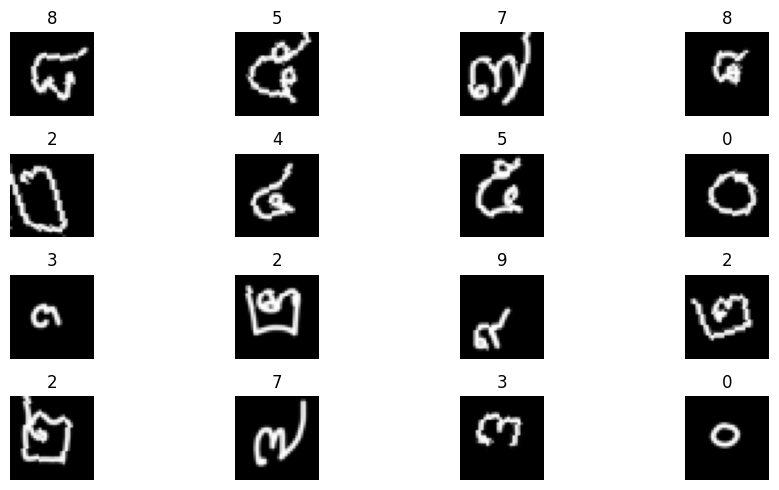

In [54]:
### START CODE HERE ###
def imshow_grid(images,labels):
    fig = plt.figure(figsize=(10, 5))
    num_images = len(images)
    grid_size = int(np.ceil(np.sqrt(num_images)))
    
    for i in range(num_images):
        a = fig.add_subplot(grid_size, grid_size, i + 1)
        img = images[i]
        img = np.transpose(img, (1, 2, 0))
        img = np.clip(img, 0, 1)
        # print(img.shape)
        plt.imshow(img, cmap="Grays")
        a.axis("off")
        
        plt.title(str(labels[i].item()))
        # print(img.shape)
    plt.tight_layout()
    plt.show()
    
path = 'thai-handwriting-number.appspot.com'  # Replace with your actual dataset path
train_loader, test_loader = load_data(path)
images, labels = next(iter(train_loader))
imshow_grid(images,labels)

### END CODE HERE ###

### **Create Models**
**CustomLeNet**:
- **Input**:  RGB images
- **Architecture**: Multiple convolutional layers with ReLU activations, followed by fully connected layers with ReLU activations
- **Description**: This is a convolutional neural network with two convolutional layers followed by two fully connected layers. It applies convolutional operations with ReLU activations, followed by flattening the output and passing through fully connected layers with ReLU activations. Finally, it produces a single neuron output with sigmoid activation.


In [55]:
### START CODE HERE ###
class CustomLeNet(nn.Module):
    def __init__(self):
        super(CustomLeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5,stride=1,padding=0)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5,stride=1,padding=0)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5,stride=1,padding=0)
        
        self.fc1 = nn.Linear(in_features=120, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=10)
        
        self.avg_pool = nn.AvgPool2d(kernel_size=2,stride=2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.avg_pool(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.avg_pool(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        
        # Flatten the output from conv layers
        x = x.view(x.shape[0], -1)
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        
        x = self.sigmoid(x)
        
        return x
        
        

### END CODE HERE ###



Complete the `train()` function in the cell below. This function should evaluate the model at every epoch, log the training loss/accuracy, test loss/accuracy. Additionally, it should save the model at the last epoch.

Resource : [PyTorch Training loop](<https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#:~:text=%3D0.9)-,The%20Training%20Loop,-Below%2C%20we%20have>)


In [56]:
def train(model,opt,loss_fn,train_loader,test_loader,epochs=10,checkpoint_path=None,device='cpu'):
    ### START CODE HERE ###
    model = model.to(device)
    
    # Store losses and accuracies
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]"):
            images, labels = images.to(device), labels.to(device)
            
            opt.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            opt.step()
            
            # Accumulate the loss and accuracy
            running_train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_loss = running_train_loss / len(train_loader.dataset)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation phase (testing)
        model.eval()
        running_test_loss = 0.0
        correct_test = 0
        total_test = 0
        
        with torch.no_grad():
            for images, labels in tqdm(test_loader, desc=f"Epoch {epoch+1}/{epochs} [Testing]"):
                images, labels = images.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                
                # Accumulate test loss and accuracy
                running_test_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        
        test_loss = running_test_loss / len(test_loader.dataset)
        test_accuracy = correct_test / total_test
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
        # Logging the results
        print(f"Epoch {epoch+1}/{epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    
    # Save the model at the last epoch if checkpoint path is provided
    if checkpoint_path:
            torch.save(model.state_dict(), f'{checkpoint_path}_epoch_{epoch+1}.pth')
            print(f'Model saved to {checkpoint_path}_epoch_{epoch+1}.pth')
    
    return train_losses, test_losses, train_accuracies, test_accuracies




    ### END CODE HERE ###

Use your `train()` function to train models.

In [57]:
### START CODE HERE ###
model = CustomLeNet()
opt = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
train(model, opt, loss_fn, train_loader, test_loader, epochs=50, checkpoint_path='trained/lenet.pth', device='cuda' if torch.cuda.is_available() else 'cpu')

### END CODE HERE ###

Epoch 1/50 [Testing]: 100%|██████████| 43/43 [00:01<00:00, 32.90it/s]


Epoch 1/50:
Train Loss: 2.2699, Train Accuracy: 0.1801
Test Loss: 2.1881, Test Accuracy: 0.3852


Epoch 2/50 [Testing]: 100%|██████████| 43/43 [00:01<00:00, 32.60it/s]


Epoch 2/50:
Train Loss: 2.1796, Train Accuracy: 0.3583
Test Loss: 2.1523, Test Accuracy: 0.4331


Epoch 3/50 [Testing]: 100%|██████████| 43/43 [00:01<00:00, 31.54it/s]


Epoch 3/50:
Train Loss: 2.1575, Train Accuracy: 0.4100
Test Loss: 2.1451, Test Accuracy: 0.4462


Epoch 4/50 [Testing]: 100%|██████████| 43/43 [00:01<00:00, 34.57it/s]


Epoch 4/50:
Train Loss: 2.1360, Train Accuracy: 0.4311
Test Loss: 2.1082, Test Accuracy: 0.4506


Epoch 5/50 [Testing]: 100%|██████████| 43/43 [00:01<00:00, 33.30it/s]


Epoch 5/50:
Train Loss: 2.0936, Train Accuracy: 0.4725
Test Loss: 2.0930, Test Accuracy: 0.4985


Epoch 6/50 [Testing]: 100%|██████████| 43/43 [00:01<00:00, 34.24it/s]


Epoch 6/50:
Train Loss: 2.0824, Train Accuracy: 0.4980
Test Loss: 2.0945, Test Accuracy: 0.4985


Epoch 7/50 [Testing]: 100%|██████████| 43/43 [00:01<00:00, 32.96it/s]


Epoch 7/50:
Train Loss: 2.0794, Train Accuracy: 0.4925
Test Loss: 2.0801, Test Accuracy: 0.5262


Epoch 8/50 [Testing]: 100%|██████████| 43/43 [00:01<00:00, 33.84it/s]


Epoch 8/50:
Train Loss: 2.0708, Train Accuracy: 0.5100
Test Loss: 2.0767, Test Accuracy: 0.5203


Epoch 9/50 [Testing]: 100%|██████████| 43/43 [00:01<00:00, 31.61it/s]


Epoch 9/50:
Train Loss: 2.0688, Train Accuracy: 0.5147
Test Loss: 2.0729, Test Accuracy: 0.5189


Epoch 10/50 [Testing]: 100%|██████████| 43/43 [00:01<00:00, 33.03it/s]


Epoch 10/50:
Train Loss: 2.0625, Train Accuracy: 0.5227
Test Loss: 2.0684, Test Accuracy: 0.5436


Epoch 11/50 [Testing]: 100%|██████████| 43/43 [00:01<00:00, 34.18it/s]


Epoch 11/50:
Train Loss: 2.0585, Train Accuracy: 0.5351
Test Loss: 2.0663, Test Accuracy: 0.5436


Epoch 12/50 [Testing]: 100%|██████████| 43/43 [00:01<00:00, 33.47it/s]


Epoch 12/50:
Train Loss: 2.0474, Train Accuracy: 0.5628
Test Loss: 2.0495, Test Accuracy: 0.5567


Epoch 13/50 [Testing]: 100%|██████████| 43/43 [00:01<00:00, 33.31it/s]


Epoch 13/50:
Train Loss: 2.0335, Train Accuracy: 0.5922
Test Loss: 2.0438, Test Accuracy: 0.5872


Epoch 14/50 [Testing]: 100%|██████████| 43/43 [00:01<00:00, 33.35it/s]


Epoch 14/50:
Train Loss: 2.0241, Train Accuracy: 0.5940
Test Loss: 2.0390, Test Accuracy: 0.5988


Epoch 15/50 [Testing]: 100%|██████████| 43/43 [00:01<00:00, 34.00it/s]


Epoch 15/50:
Train Loss: 2.0235, Train Accuracy: 0.5933
Test Loss: 2.0456, Test Accuracy: 0.5872


Epoch 16/50 [Testing]: 100%|██████████| 43/43 [00:01<00:00, 34.13it/s]


Epoch 16/50:
Train Loss: 2.0169, Train Accuracy: 0.5966
Test Loss: 2.0287, Test Accuracy: 0.6119


Epoch 17/50 [Testing]: 100%|██████████| 43/43 [00:01<00:00, 34.00it/s]


Epoch 17/50:
Train Loss: 2.0185, Train Accuracy: 0.6028
Test Loss: 2.0288, Test Accuracy: 0.6163


Epoch 18/50 [Testing]: 100%|██████████| 43/43 [00:01<00:00, 30.69it/s]


Epoch 18/50:
Train Loss: 2.0151, Train Accuracy: 0.6115
Test Loss: 2.0221, Test Accuracy: 0.6192


Epoch 19/50 [Testing]: 100%|██████████| 43/43 [00:01<00:00, 33.07it/s]


Epoch 19/50:
Train Loss: 2.0116, Train Accuracy: 0.6137
Test Loss: 2.0201, Test Accuracy: 0.6192


Epoch 20/50 [Testing]: 100%|██████████| 43/43 [00:01<00:00, 32.90it/s]


Epoch 20/50:
Train Loss: 2.0140, Train Accuracy: 0.6057
Test Loss: 2.0222, Test Accuracy: 0.6119


Epoch 21/50 [Testing]: 100%|██████████| 43/43 [00:01<00:00, 34.40it/s]


Epoch 21/50:
Train Loss: 2.0084, Train Accuracy: 0.6188
Test Loss: 2.0151, Test Accuracy: 0.6439


Epoch 22/50 [Testing]: 100%|██████████| 43/43 [00:01<00:00, 33.48it/s]


Epoch 22/50:
Train Loss: 2.0072, Train Accuracy: 0.6210
Test Loss: 2.0152, Test Accuracy: 0.6352


Epoch 23/50 [Testing]: 100%|██████████| 43/43 [00:01<00:00, 34.65it/s]


Epoch 23/50:
Train Loss: 2.0058, Train Accuracy: 0.6104
Test Loss: 2.0198, Test Accuracy: 0.5901


Epoch 24/50 [Testing]: 100%|██████████| 43/43 [00:01<00:00, 34.71it/s]


Epoch 24/50:
Train Loss: 2.0080, Train Accuracy: 0.6144
Test Loss: 2.0175, Test Accuracy: 0.6206


Epoch 25/50 [Testing]: 100%|██████████| 43/43 [00:01<00:00, 34.30it/s]


Epoch 25/50:
Train Loss: 2.0050, Train Accuracy: 0.6210
Test Loss: 2.0261, Test Accuracy: 0.5770


Epoch 26/50 [Testing]: 100%|██████████| 43/43 [00:01<00:00, 33.30it/s]


Epoch 26/50:
Train Loss: 2.0012, Train Accuracy: 0.6355
Test Loss: 2.0194, Test Accuracy: 0.6177


Epoch 27/50 [Testing]: 100%|██████████| 43/43 [00:01<00:00, 32.51it/s]


Epoch 27/50:
Train Loss: 2.0053, Train Accuracy: 0.6220
Test Loss: 2.0155, Test Accuracy: 0.6265


Epoch 28/50 [Testing]: 100%|██████████| 43/43 [00:01<00:00, 34.20it/s]


Epoch 28/50:
Train Loss: 2.0023, Train Accuracy: 0.6246
Test Loss: 2.0143, Test Accuracy: 0.6308


Epoch 29/50 [Testing]: 100%|██████████| 43/43 [00:01<00:00, 34.76it/s]


Epoch 29/50:
Train Loss: 2.0004, Train Accuracy: 0.6326
Test Loss: 2.0164, Test Accuracy: 0.6250


Epoch 30/50 [Testing]: 100%|██████████| 43/43 [00:01<00:00, 33.40it/s]


Epoch 30/50:
Train Loss: 2.0006, Train Accuracy: 0.6290
Test Loss: 2.0120, Test Accuracy: 0.6265


Epoch 31/50 [Testing]: 100%|██████████| 43/43 [00:01<00:00, 34.43it/s]


Epoch 31/50:
Train Loss: 1.9994, Train Accuracy: 0.6340
Test Loss: 2.0074, Test Accuracy: 0.6395


Epoch 32/50 [Testing]: 100%|██████████| 43/43 [00:01<00:00, 33.49it/s]


Epoch 32/50:
Train Loss: 2.0028, Train Accuracy: 0.6253
Test Loss: 2.0224, Test Accuracy: 0.5988


Epoch 33/50 [Testing]: 100%|██████████| 43/43 [00:01<00:00, 33.18it/s]


Epoch 33/50:
Train Loss: 1.9986, Train Accuracy: 0.6319
Test Loss: 2.0147, Test Accuracy: 0.6279


Epoch 34/50 [Testing]: 100%|██████████| 43/43 [00:01<00:00, 32.31it/s]


Epoch 34/50:
Train Loss: 1.9984, Train Accuracy: 0.6242
Test Loss: 2.0060, Test Accuracy: 0.6366


Epoch 35/50 [Testing]: 100%|██████████| 43/43 [00:01<00:00, 37.76it/s]


Epoch 35/50:
Train Loss: 1.9952, Train Accuracy: 0.6406
Test Loss: 2.0203, Test Accuracy: 0.6148


Epoch 36/50 [Testing]: 100%|██████████| 43/43 [00:00<00:00, 47.88it/s]


Epoch 36/50:
Train Loss: 1.9962, Train Accuracy: 0.6391
Test Loss: 2.0109, Test Accuracy: 0.6381


Epoch 37/50 [Testing]: 100%|██████████| 43/43 [00:00<00:00, 48.07it/s]


Epoch 37/50:
Train Loss: 1.9965, Train Accuracy: 0.6366
Test Loss: 2.0216, Test Accuracy: 0.6076


Epoch 38/50 [Testing]: 100%|██████████| 43/43 [00:00<00:00, 47.78it/s]


Epoch 38/50:
Train Loss: 1.9981, Train Accuracy: 0.6308
Test Loss: 2.0120, Test Accuracy: 0.6294


Epoch 39/50 [Testing]: 100%|██████████| 43/43 [00:00<00:00, 48.05it/s]


Epoch 39/50:
Train Loss: 1.9934, Train Accuracy: 0.6424
Test Loss: 2.0094, Test Accuracy: 0.6395


Epoch 40/50 [Testing]: 100%|██████████| 43/43 [00:00<00:00, 48.03it/s]


Epoch 40/50:
Train Loss: 1.9939, Train Accuracy: 0.6417
Test Loss: 2.0072, Test Accuracy: 0.6337


Epoch 41/50 [Testing]: 100%|██████████| 43/43 [00:01<00:00, 39.93it/s]


Epoch 41/50:
Train Loss: 1.9915, Train Accuracy: 0.6544
Test Loss: 2.0082, Test Accuracy: 0.6424


Epoch 42/50 [Testing]: 100%|██████████| 43/43 [00:00<00:00, 46.28it/s]


Epoch 42/50:
Train Loss: 1.9906, Train Accuracy: 0.6511
Test Loss: 2.0148, Test Accuracy: 0.6337


Epoch 43/50 [Testing]: 100%|██████████| 43/43 [00:00<00:00, 46.63it/s]


Epoch 43/50:
Train Loss: 1.9912, Train Accuracy: 0.6566
Test Loss: 2.0054, Test Accuracy: 0.6512


Epoch 44/50 [Testing]: 100%|██████████| 43/43 [00:00<00:00, 48.10it/s]


Epoch 44/50:
Train Loss: 1.9940, Train Accuracy: 0.6464
Test Loss: 2.0094, Test Accuracy: 0.6410


Epoch 45/50 [Testing]: 100%|██████████| 43/43 [00:00<00:00, 45.78it/s]


Epoch 45/50:
Train Loss: 1.9896, Train Accuracy: 0.6530
Test Loss: 1.9981, Test Accuracy: 0.6613


Epoch 46/50 [Testing]: 100%|██████████| 43/43 [00:00<00:00, 47.94it/s]


Epoch 46/50:
Train Loss: 1.9885, Train Accuracy: 0.6471
Test Loss: 2.0016, Test Accuracy: 0.6613


Epoch 47/50 [Testing]: 100%|██████████| 43/43 [00:00<00:00, 47.07it/s]


Epoch 47/50:
Train Loss: 1.9890, Train Accuracy: 0.6541
Test Loss: 2.0052, Test Accuracy: 0.6497


Epoch 48/50 [Testing]: 100%|██████████| 43/43 [00:00<00:00, 48.10it/s]


Epoch 48/50:
Train Loss: 1.9866, Train Accuracy: 0.6613
Test Loss: 2.0055, Test Accuracy: 0.6453


Epoch 49/50 [Testing]: 100%|██████████| 43/43 [00:00<00:00, 46.00it/s]


Epoch 49/50:
Train Loss: 1.9913, Train Accuracy: 0.6501
Test Loss: 2.0148, Test Accuracy: 0.6279


Epoch 50/50 [Testing]: 100%|██████████| 43/43 [00:00<00:00, 48.86it/s]

Epoch 50/50:
Train Loss: 1.9858, Train Accuracy: 0.6581
Test Loss: 2.0056, Test Accuracy: 0.6628
Model saved to trained/lenet.pth_epoch_50.pth


([2.269903783409671,
  2.179563573075451,
  2.1574809384718945,
  2.1359632217307314,
  2.09361374798841,
  2.082435431502957,
  2.0793890991224813,
  2.0707895558892533,
  2.068828179906524,
  2.062523851441487,
  2.058530587896775,
  2.0473584507803086,
  2.033494708233636,
  2.0241375089168723,
  2.023521598446105,
  2.016931684288644,
  2.0184824540425144,
  2.015138497479225,
  2.0116454600940923,
  2.013998312358641,
  2.0083525454447284,
  2.007199660436853,
  2.005816344392651,
  2.00802960158175,
  2.0050073543345985,
  2.0011873180192357,
  2.0053050775621624,
  2.0023104934616063,
  2.000363491890256,
  2.0005827898890725,
  1.9994202723022634,
  2.00277257152105,
  1.9985582812043179,
  1.9983809297845423,
  1.9951998120266639,
  1.996162643862794,
  1.9965274759360598,
  1.9980521280143686,
  1.9933940730731503,
  1.9938718457359017,
  1.9914719492099466,
  1.9905670593764053,
  1.9911591574771919,
  1.9939543112012073,
  1.9896443645144948,
  1.9885427479138589,
  1.98899

Try to load the weights into the model and the confusion matrix.

C:\Users\sitth\AppData\Local\Temp\ipykernel_24776\4291245551.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_locati

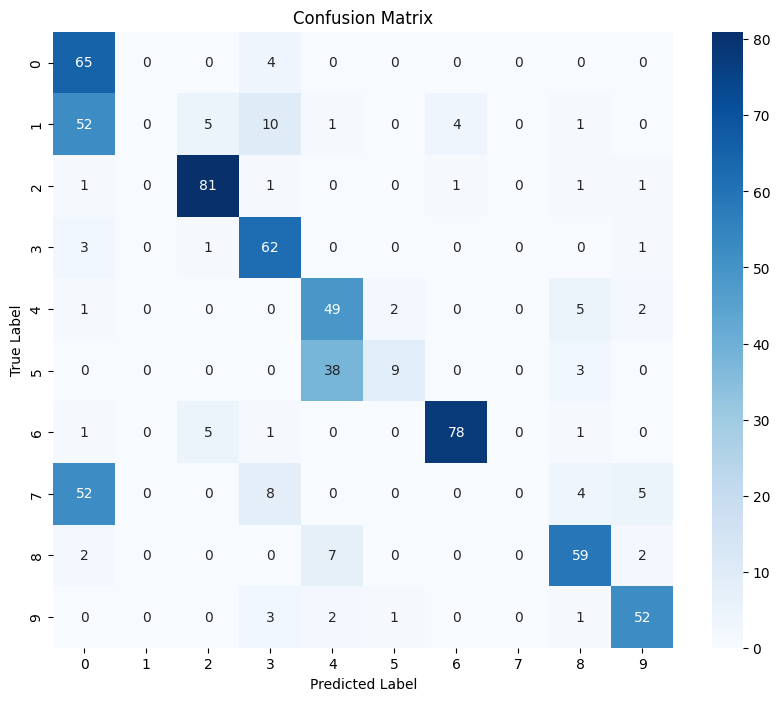

In [63]:
### START CODE HERE ###
from sklearn.metrics import confusion_matrix
import seaborn as sns
model = CustomLeNet()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)  # Move model to the same device
checkpoint_path = 'trained/lenet.pth_epoch_50.pth'  # Specify the correct path to your saved weights
model.load_state_dict(torch.load(checkpoint_path, map_location=device))  # Load weights to the correct device
model.eval()  # Set the model to evaluation mode

# Function to get predictions and true labels
def get_predictions(model, test_loader, device='cpu'):
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Ensure both are on the same device
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_labels), np.array(all_preds)

# Get the true labels and predictions
true_labels, predicted_labels = get_predictions(model, test_loader, device)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=list(range(10)), yticklabels=list(range(10)))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()
### END CODE HERE ###

Visualize the feature map of ***ALL*** layers of the Convolution Feature Extractor part. Then, save it as an image

In [65]:
### START CODE HERE ###
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

class FeatureExtractor(nn.Module):
    def __init__(self, model, target_layers):
        super(FeatureExtractor, self).__init__()
        self.model = copy.deepcopy(model)
        self.target_layers = target_layers
        self.features = []

        for layer_name, layer in self.model.named_modules():
            if layer_name in target_layers:
                layer.register_forward_hook(self.save_feature(layer_name))

    def save_feature(self, layer_name):
        def hook(module, input, output):
            self.features.append(output)
        return hook

    def forward(self, x):
        self.features = []
        self.model(x)
        return self.features

def visualize_feature_map(feature_maps, base_filename):
    for layer_idx, feature in enumerate(feature_maps):
        # Convert feature map to numpy array
        feature_np = feature.cpu().detach().numpy()
        # Get the number of channels
        num_channels = feature_np.shape[1]
        # Determine grid size
        grid_size = int(np.ceil(np.sqrt(num_channels)))
        fig, axs = plt.subplots(grid_size, grid_size, figsize=(20, 20))
        fig.suptitle(f'Feature Maps for Layer {layer_idx + 1}', fontsize=16)
        axs = axs.flatten() if isinstance(axs, np.ndarray) else [axs]
        for i in range(num_channels):
            if i < len(axs):
                axs[i].imshow(feature_np[0, i], cmap='gray')
                axs[i].axis('off')
                axs[i].set_title(f'Channel {i + 1}')
        # Remove unused subplots
        for i in range(num_channels, len(axs)):
            fig.delaxes(axs[i])
        plt.tight_layout()
        plt.savefig(f"{base_filename}_layer_{layer_idx + 1}.png")
        plt.close()
    
    print(f"Feature maps saved with base filename: {base_filename}")

# Load your model and weights
checkpoint_path = 'trained/lenet.pth_epoch_50.pth'  # Update this to your actual path
model = CustomLeNet()

# Load model weights directly onto the device
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

# Move the model to the device
model.to(device)

# Specify the layers to extract features from
target_layers = ["conv1", "conv2", "conv3"]  # Update this with your layer names
extractor = FeatureExtractor(model, target_layers)

# Get a batch of images
images, _ = next(iter(test_loader))  # Get a batch from your DataLoader
batch = images.to(device).float()  # Ensure the batch is on the correct device

# Extract features
feature_maps = extractor(batch)

# Visualize and save feature maps
visualize_feature_map(feature_maps, base_filename="all_feature_maps")




### END CODE HERE ###

C:\Users\sitth\AppData\Local\Temp\ipykernel_24776\2895522636.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_locat

Feature maps saved with base filename: all_feature_maps


---
# Questions
1. Identify the top 3 classes with the worst F1 scores and perform an in-depth analysis of the model’s behavior on misclassified images. Analyze the feature map of an incorrectly predicted image from each class and compare it with the feature map of a correctly predicted image from the same class.
2. Does a deeper model always lead to better performance? Discuss this by considering factors such as overfitting, training time, data complexity, and model capacity. Provide examples from relevant experiments to support your argument.
